In [1]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 655.6 kB/s eta 0:00:000:00:01


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# TensorFlow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# System Libraries
from pathlib import Path
import os
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [3]:
data = pd.read_csv('/kaggle/input/100-bird-species/birds.csv')
data.head(10)

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
5,0.0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
6,0.0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
7,0.0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
8,0.0,train/ABBOTTS BABBLER/006.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
9,0.0,train/ABBOTTS BABBLER/010.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


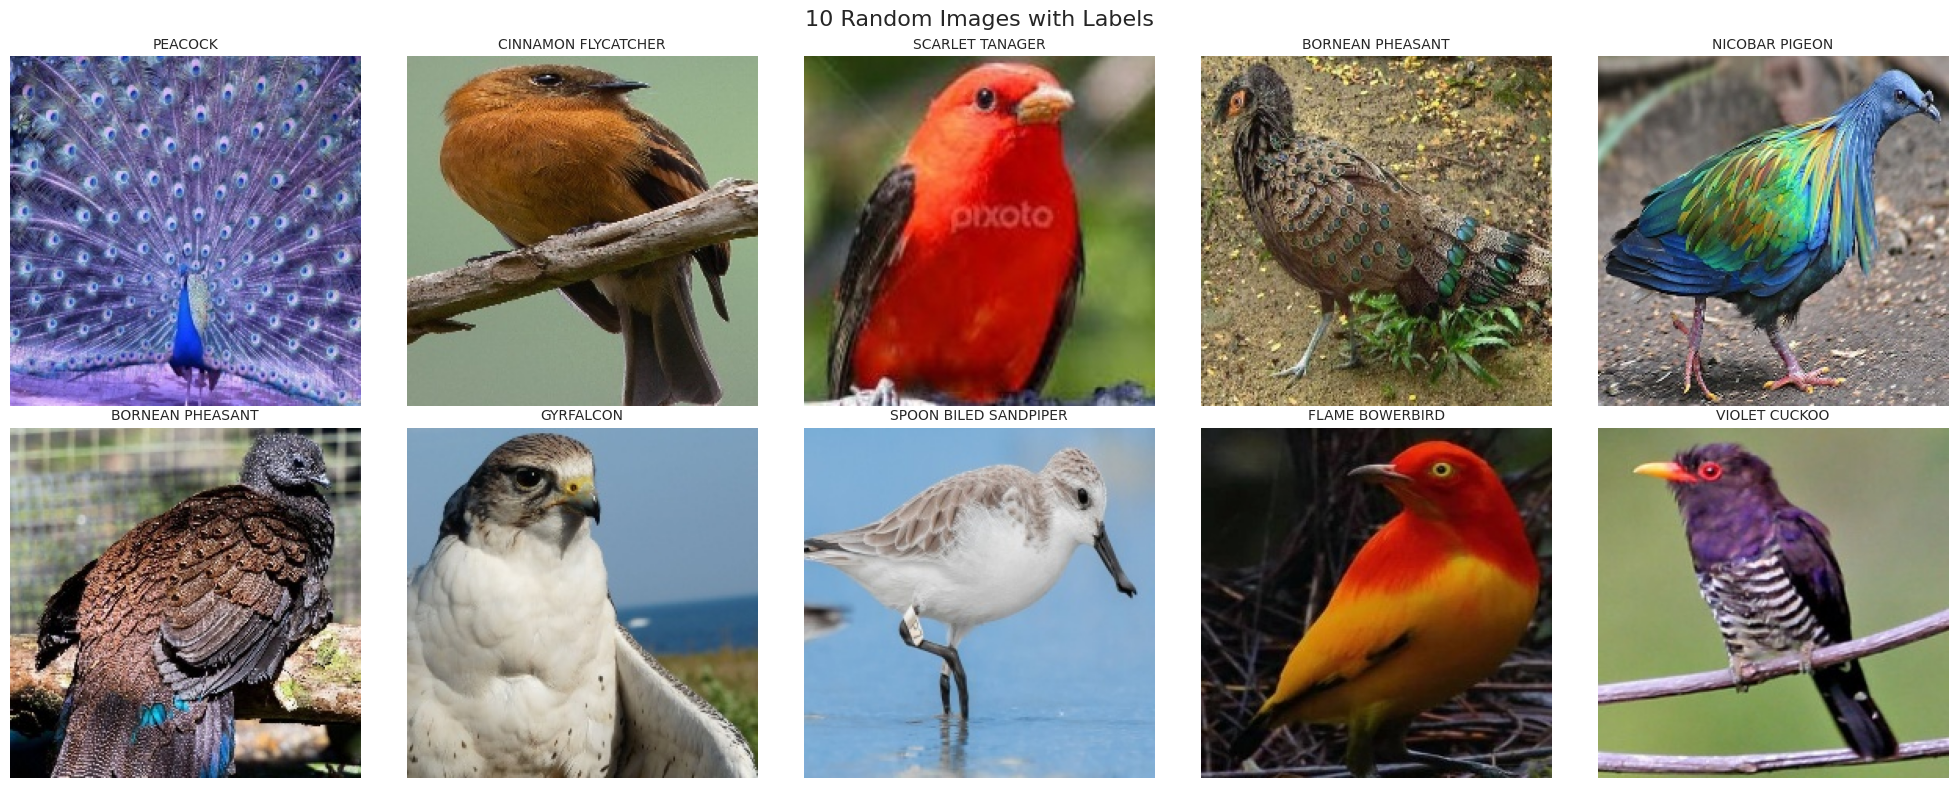

In [4]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Đường dẫn đến thư mục chứa ảnh
base_dir = '/kaggle/input/100-bird-species/train'

# Lấy danh sách tất cả các thư mục con (mỗi thư mục con tương ứng với một nhãn)
labels = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Chọn ngẫu nhiên 10 ảnh
num_images_to_show = 10
random_images = []

for _ in range(num_images_to_show):
    # Chọn ngẫu nhiên một nhãn
    label = random.choice(labels)
    label_dir = os.path.join(base_dir, label)

    image_name = random.choice(os.listdir(label_dir))
    image_path = os.path.join(label_dir, image_name)
    
    random_images.append((image_path, label))

# Hiển thị ảnh
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('10 Random Images with Labels', fontsize=16)

for i, (image_path, label) in enumerate(random_images):
    ax = axes[i // 5, i % 5]
    
    # Đọc và hiển thị ảnh
    img = Image.open(image_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{label}", fontsize=10)

plt.tight_layout()
plt.show()

In [5]:
train_path = "/kaggle/input/100-bird-species/train"
valid_path = "/kaggle/input/100-bird-species/valid"
test_path = "/kaggle/input/100-bird-species/test"

In [6]:
image_dir_train = Path(train_path)

# Get filepaths and labels
filepaths_train = list(image_dir_train.glob(r'**/*.JPG')) + list(image_dir_train.glob(r'**/*.jpg')) + list(image_dir_train.glob(r'**/*.png')) + list(image_dir_train.glob(r'**/*.png'))

train_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_train))

filepaths_train = pd.Series(filepaths_train, name='Filepath').astype(str)
train_labels = pd.Series(train_labels, name='Label')

# Concatenate filepaths and labels
image_df_train = pd.concat([filepaths_train, train_labels], axis=1)

In [7]:
image_dir_valid = Path(valid_path)

# Get filepaths and labels
filepaths_valid = list(image_dir_valid.glob(r'**/*.JPG')) + list(image_dir_valid.glob(r'**/*.jpg')) + list(image_dir_valid.glob(r'**/*.png')) + list(image_dir_valid.glob(r'**/*.png'))

valid_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_valid))

filepaths_valid = pd.Series(filepaths_valid, name='Filepath').astype(str)
valid_labels = pd.Series(valid_labels, name='Label')

# Concatenate filepaths and labels
image_df_valid = pd.concat([filepaths_valid, valid_labels], axis=1)

In [8]:
image_dir_test = Path(test_path)

# Get filepaths and labels
filepaths_test = list(image_dir_test.glob(r'**/*.JPG')) + list(image_dir_test.glob(r'**/*.jpg')) + list(image_dir_test.glob(r'**/*.png')) + list(image_dir_test.glob(r'**/*.png'))

test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_test))

filepaths_test = pd.Series(filepaths_test, name='Filepath').astype(str)
test_labels = pd.Series(test_labels, name='Label')

# Concatenate filepaths and labels
image_df_test = pd.concat([filepaths_test, test_labels], axis=1)

In [9]:
filepaths_train = pd.Series(filepaths_train, name='Filepath').astype(str)
train_labels = pd.Series(train_labels, name='Label')
image_df_train = pd.concat([filepaths_train, train_labels], axis=1)


filepaths_valid = pd.Series(filepaths_valid, name='Filepath').astype(str)
valid_labels = pd.Series(valid_labels, name='Label')
image_df_valid = pd.concat([filepaths_valid, valid_labels], axis=1)


filepaths_test = pd.Series(filepaths_test, name='Filepath').astype(str)
test_labels = pd.Series(test_labels, name='Label')
image_df_test = pd.concat([filepaths_test, test_labels], axis=1)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# ImageDataGenerator for validation and test (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=image_df_train,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=image_df_valid,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=image_df_test,
    x_col="Filepath",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 84635 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.


In [11]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model


def create_xception(input_shape=(224, 224, 3), num_classes=525):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

In [12]:
input_shape = (224, 224, 3)
num_classes = 525
model = create_xception(input_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 23,497,781 (89.64 MB)

 Trainable params: 23,443,253 (89.43 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
batch_size = 32

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6)

# Calculate steps per epoch
train_steps_per_epoch = train_generator.n // batch_size
valid_steps_per_epoch = valid_generator.n // batch_size

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=valid_steps_per_epoch,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724599438.784332     124 service.cc:145] XLA service 0x78f9ec003e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724599438.784385     124 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724599438.784389     124 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724599470.935720     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 950/2644 ━━━━━━━━━━━━━━━━━━━━ 17:02 603ms/step - accuracy: 0.0037 - loss: 6.1705